# Prepare

In [ ]:
!pip install pyspark
!pip install nbformat

# EDA

## Import data

In [ ]:
# Imports and Spark Session Setup
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, when, count, desc, sum, array_contains, split, regexp_extract, to_date, month, year, lit, size, explode
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

spark = (
    SparkSession.builder
    .appName("JobMarketDeepDive")
    .config("spark.memory.offHeap.enabled", "true")
    .config("spark.memory.offHeap.size", "10g")
    .getOrCreate()
)

# Set Plot Style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

### Generate Dataframe from the csv data.

In [ ]:
file_path_job_skills = "../resources/job_skills.csv"
file_path_job_summary = "../resources/job_summary.csv"
file_path_job_postings = "../resources/linkedin_job_postings.csv"

df_skills = spark.read.csv(file_path_job_skills, header=True, escape='"', inferSchema=True)
df_job_summary = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .option("multiline","true")\
  .option("quote", '"')\
  .option("escape", '\"')\
  .load(file_path_job_summary)
df_postings = spark.read.csv(file_path_job_postings, header=True, escape='"', inferSchema=True)


## Check top data

In [7]:
df_job_skills.show(20,0)

+------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|job_link                               

In [8]:
df_job_summary.show(20,0)

+-------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
df_job_postings.show(20,0)

+---------------------------------------------------------------------------------------------------------------------------------+-----------------------------+-----------+-------+---------------+--------------------------------------------------------------------------+-------------------------------------+----------------------------------+----------+---------------+--------------+------------------------------------+----------+--------+
|job_link                                                                                                                         |last_processed_time          |got_summary|got_ner|is_being_worked|job_title                                                                 |company                              |job_location                      |first_seen|search_city    |search_country|search_position                     |job_level |job_type|
+-------------------------------------------------------------------------------------------------------------

### Define and verify the schema of the dataset

In [10]:
# Display schema of the dataframes
print("Schema of df_job_skills:")
df_job_skills.printSchema()

print("Schema of df_job_summary:")
df_job_summary.printSchema()

print("Schema of df_job_postings:")
df_job_postings.printSchema()

Schema of df_job_skills:
root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)

Schema of df_job_summary:
root
 |-- job_link: string (nullable = true)
 |-- job_summary: string (nullable = true)

Schema of df_job_postings:
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)



## Print the number of rows and columns.

In [11]:
# Print the number of rows and columns
print(f"df_job_skills: {df_job_skills.count()} rows, {len(df_job_skills.columns)} columns")
print(f"df_job_summary: {df_job_summary.count()} rows, {len(df_job_summary.columns)} columns")
print(f"df_job_postings: {df_job_postings.count()} rows, {len(df_job_postings.columns)} columns")

df_job_skills: 1296381 rows, 2 columns


df_job_summary: 1297332 rows, 2 columns
df_job_postings: 1348488 rows, 14 columns


## Obtain the descriptive statistics

In [12]:
# Obtain descriptive statistics
print("Descriptive statistics for df_job_skills:")
df_job_skills.describe().show()

Descriptive statistics for df_job_skills:


+-------+--------------------+-------------------------------+
|summary|            job_link|                     job_skills|
+-------+--------------------+-------------------------------+
|  count|             1296381|                        1294374|
|   mean|                NULL|                           NULL|
| stddev|                NULL|                           NULL|
|    min|https://ae.linked...|           $1952 per week, T...|
|    max|https://za.linked...|志愿服务, 沟通, 陪伴, 临终服...|
+-------+--------------------+-------------------------------+



In [13]:
# Obtain descriptive statistics
print("Descriptive statistics for df_job_summary:")
df_job_summary.describe().show()

Descriptive statistics for df_job_summary:


+-------+--------------------+--------------------+
|summary|            job_link|         job_summary|
+-------+--------------------+--------------------+
|  count|             1297332|             1297332|
|   mean|                NULL|                NULL|
| stddev|                NULL|                NULL|
|    min|https://ae.linked...|! CURRENTLY SEEKI...|
|    max|https://za.linked...|🪠 We invite full...|
+-------+--------------------+--------------------+



In [14]:
# Obtain descriptive statistics
print("Descriptive statistics for df_job_postings:")
df_job_postings.describe().show()

25/12/11 17:09:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Descriptive statistics for df_job_postings:


+-------+--------------------+--------------------+--------------------+----------+---------------+--------------------+--------------------+--------------------+----------+-----------+--------------+----------------+----------+--------+
|summary|            job_link| last_processed_time|         got_summary|   got_ner|is_being_worked|           job_title|             company|        job_location|first_seen|search_city|search_country| search_position| job_level|job_type|
+-------+--------------------+--------------------+--------------------+----------+---------------+--------------------+--------------------+--------------------+----------+-----------+--------------+----------------+----------+--------+
|  count|             1348488|             1348488|             1348488|   1348488|        1348488|             1348488|             1348443|             1348435|   1348454|    1348420|       1348420|         1348420|   1348420| 1348420|
|   mean|                NULL|                NU

In [45]:
cols_to_lower = ["job_title", "job_location", "search_position"]

df_job_postings = df_job_postings.select(
    *[
        lower(col(c)).alias(c) if c in cols_to_lower else col(c)
        for c in df_job_postings.columns
    ]
)

# EDA Deep Dive

In [46]:
# Create a new column with the primary skill
df_job_skills_with_primary = df_job_skills.withColumn("primary_skill", split(col("job_skills"), ",")[0])
df_job_skills_with_primary.show(5, 0)

+-------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------+
|job_link                                                                                                                       |job_skills              

In [47]:
# Aggregate functions
# Count of jobs by job level
df_job_postings.groupBy("job_level").count().show()

# Count of jobs by job type
df_job_postings.groupBy("job_type").count().show()

+----------+-------+
| job_level|  count|
+----------+-------+
|      NULL|     68|
| Associate| 144009|
|Mid senior|1204411|
+----------+-------+

+--------+-------+
|job_type|  count|
+--------+-------+
|  Remote|   4259|
|  Onsite|1337599|
|    NULL|     68|
|  Hybrid|   6562|
+--------+-------+



In [48]:
df_job_postings.groupBy("search_country").count().show()

df_job_postings.groupBy("search_city").count().show()

+--------------+-------+
|search_country|  count|
+--------------+-------+
|          NULL|     68|
| United States|1149339|
|        Canada|  55971|
|     Australia|  29719|
|United Kingdom| 113391|
+--------------+-------+

+--------------+-----+
|   search_city|count|
+--------------+-----+
|     Worcester| 4526|
|          Utah|  986|
|        Nahant|  232|
|       Hanover|  214|
|     Fairbanks|  567|
|Saint Boniface|  107|
|        Corona| 1976|
|   Springfield| 1334|
|    Harrisburg|  851|
|    Charleston| 1867|
|        Hawaii| 1490|
| Bowling Green|  416|
|         Pasco|   63|
|      Manitoba| 1187|
|         Cairo|  301|
|       Batavia|  717|
|      Palatine|  295|
|    Wellington|   26|
|     Bountiful|  999|
|   Shawneetown|  140|
+--------------+-----+
only showing top 20 rows


In [49]:
# Grouping and Sorting
# Group by company and count job postings, then sort
company_counts = df_job_postings.groupBy("company").count().sort("count", ascending=False)
company_counts.show(10)

+--------------------+-----+
|             company|count|
+--------------------+-----+
|     Health eCareers|41598|
|   Jobs for Humanity|27680|
|   TravelNurseSource|16142|
|      Dollar General|14815|
|        PracticeLink| 9738|
|      Energy Jobline| 9365|
|Gotham Enterprise...| 8935|
|               Jobot| 8713|
|       ClearanceJobs| 8599|
|          McDonald's| 8125|
+--------------------+-----+
only showing top 10 rows


## Count Missing Values

In [50]:
# Count missing values in df_job_postings
df_job_postings.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_job_postings.columns]).show()

# Count missing values in df_job_summary
df_job_summary.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_job_summary.columns]).show()

# Count missing values in df_job_skills
df_job_skills.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_job_skills.columns]).show()

+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+
|job_link|last_processed_time|got_summary|got_ner|is_being_worked|job_title|company|job_location|first_seen|search_city|search_country|search_position|job_level|job_type|
+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+
|       0|                  0|          0|      0|              0|        0|     45|          53|        34|         68|            68|             68|       68|      68|
+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+



+--------+-----------+
|job_link|job_summary|
+--------+-----------+
|       0|          0|
+--------+-----------+

+--------+----------+
|job_link|job_skills|
+--------+----------+
|       0|      2007|
+--------+----------+



## Drop rows missing job skills

In [51]:
# Drop rows with missing job_skills in df_job_skills
df_job_skills_cleaned = df_job_skills.dropna(subset=["job_skills"])
print(f"Original df_job_skills count: {df_job_skills.count()}")
print(f"Cleaned df_job_skills count: {df_job_skills_cleaned.count()}")

Original df_job_skills count: 1296381
Cleaned df_job_skills count: 1294374


## Drop rows missing job postings

In [52]:
# Drop rows with missing values in key columns of df_job_postings
df_job_postings_cleaned = df_job_postings.dropna(subset=["job_title", "company", "job_location"])
print(f"Original df_job_postings count: {df_job_postings.count()}")
print(f"Cleaned df_job_postings count: {df_job_postings_cleaned.count()}")

Original df_job_postings count: 1348488
Cleaned df_job_postings count: 1348424


## JOIN dataframe on job link

In [53]:
# Join df_job_postings and df_job_skills
df_postings_skills = df_job_postings.join(df_job_skills, "job_link", "inner")
df_postings_skills.show(5)

+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+------------+--------------+------------------+----------+--------+--------------------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|           job_title|             company|        job_location|first_seen| search_city|search_country|   search_position| job_level|job_type|          job_skills|
+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+------------+--------------+------------------+----------+--------+--------------------+
|https://ae.linked...|2024-01-21 07:21:...|          t|      t|              f|        evs operator|              Sundus|abu dhabi, abu dh...|2024-01-17|Saint Joseph| United States|     unit operator|Mid senior|  Onsite|EVS, EVS Operator...|
|https://ae.linked...|2024-01-21

## Geographic Analysis

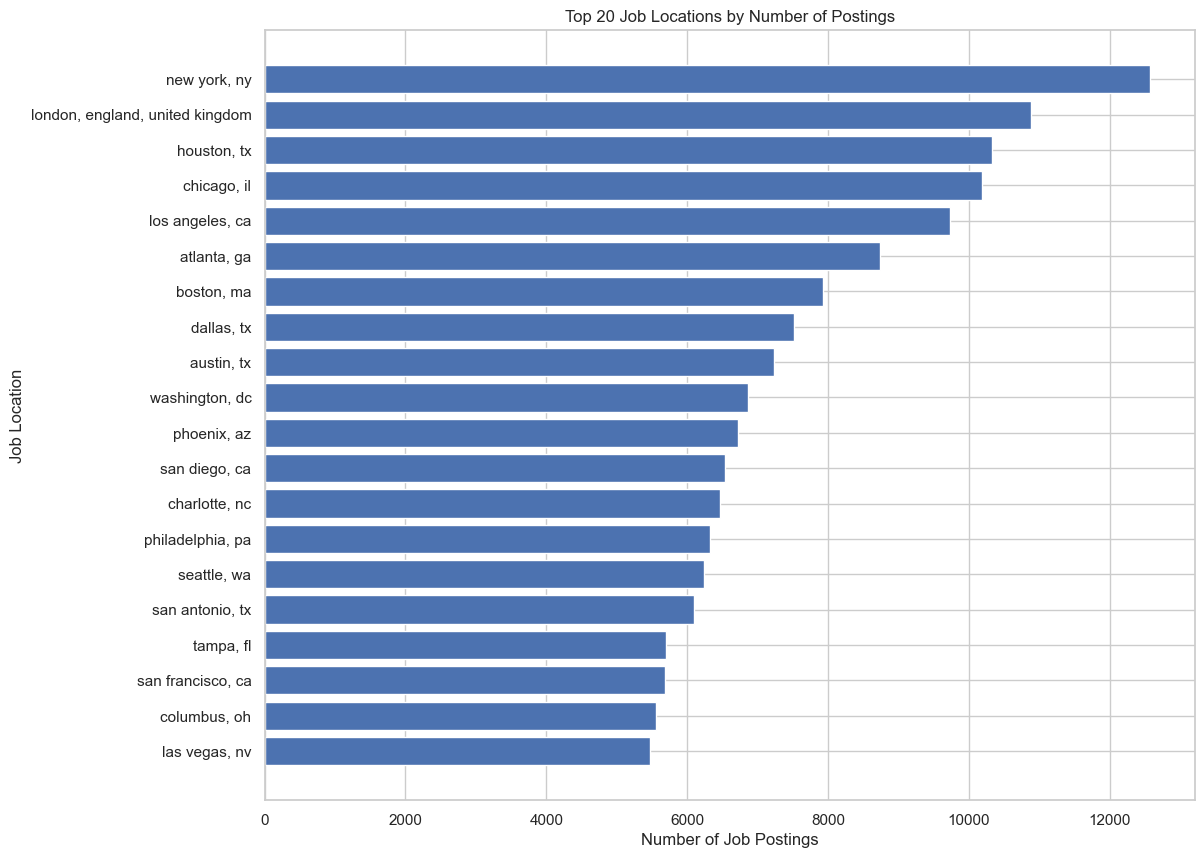

In [54]:
# Group by job location and count the number of job postings
location_counts = df_postings_skills.groupBy('job_location').count().orderBy('count', ascending=False)

# Convert to Pandas DataFrame for plotting the top 20 locations
top_locations_pd = location_counts.limit(20).toPandas()

# Plotting the top 20 job locations
plt.figure(figsize=(12, 10))
plt.barh(top_locations_pd['job_location'], top_locations_pd['count'])
plt.xlabel('Number of Job Postings')
plt.ylabel('Job Location')
plt.title('Top 20 Job Locations by Number of Postings')
plt.gca().invert_yaxis()
plt.show()

## Skills Analysis

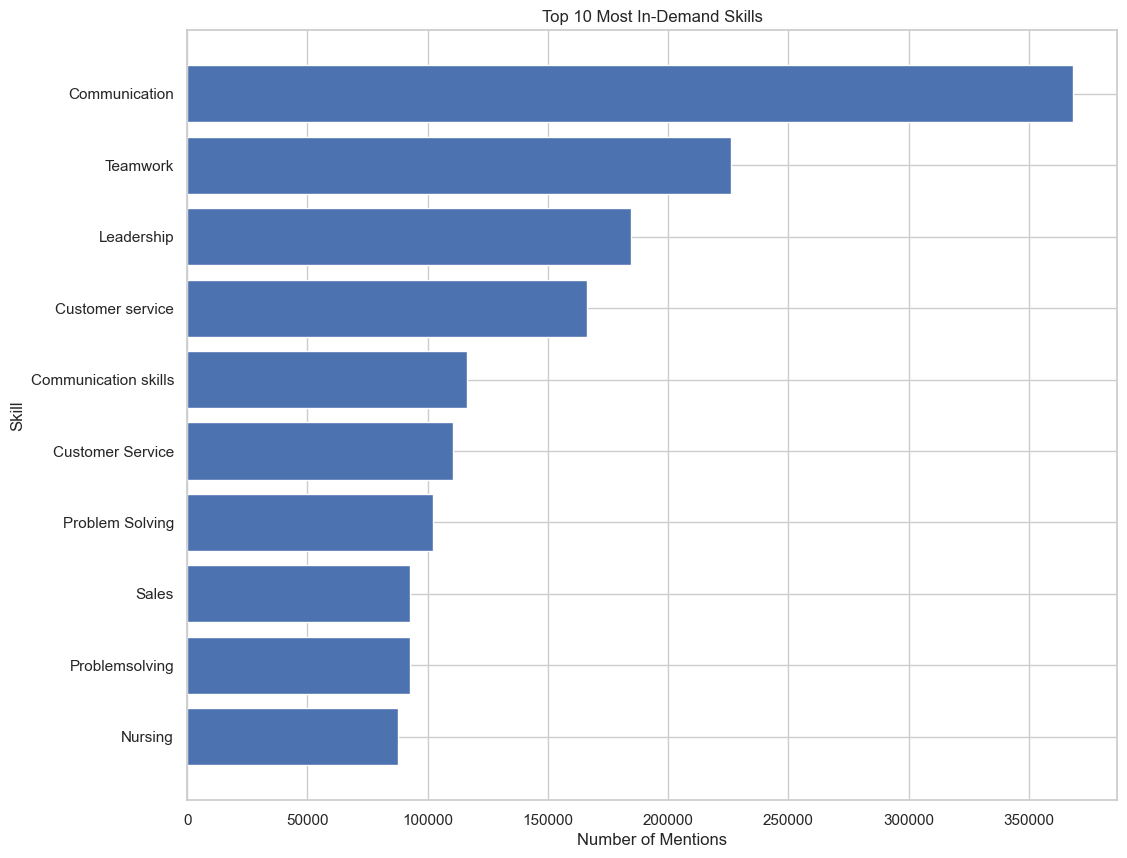

In [55]:
from pyspark.sql.functions import explode, split, trim

# Split the job_skills string into an array of skills, trim whitespace, and explode the array
skills_df = df_postings_skills.withColumn('skill', explode(split(col('job_skills'), ',')))
skills_df = skills_df.withColumn('skill', trim(col('skill')))

# Group by skill and count the occurrences
skill_counts = skills_df.groupBy('skill').count().orderBy('count', ascending=False)

# Convert to Pandas DataFrame for plotting the top skills
top_skills_pd = skill_counts.limit(10).toPandas()

# Plotting the top skills
plt.figure(figsize=(12, 10))
plt.barh(top_skills_pd['skill'], top_skills_pd['count'])
plt.xlabel('Number of Mentions')
plt.ylabel('Skill')
plt.title('Top 10 Most In-Demand Skills')
plt.gca().invert_yaxis()
plt.show()

## Job Title Trends

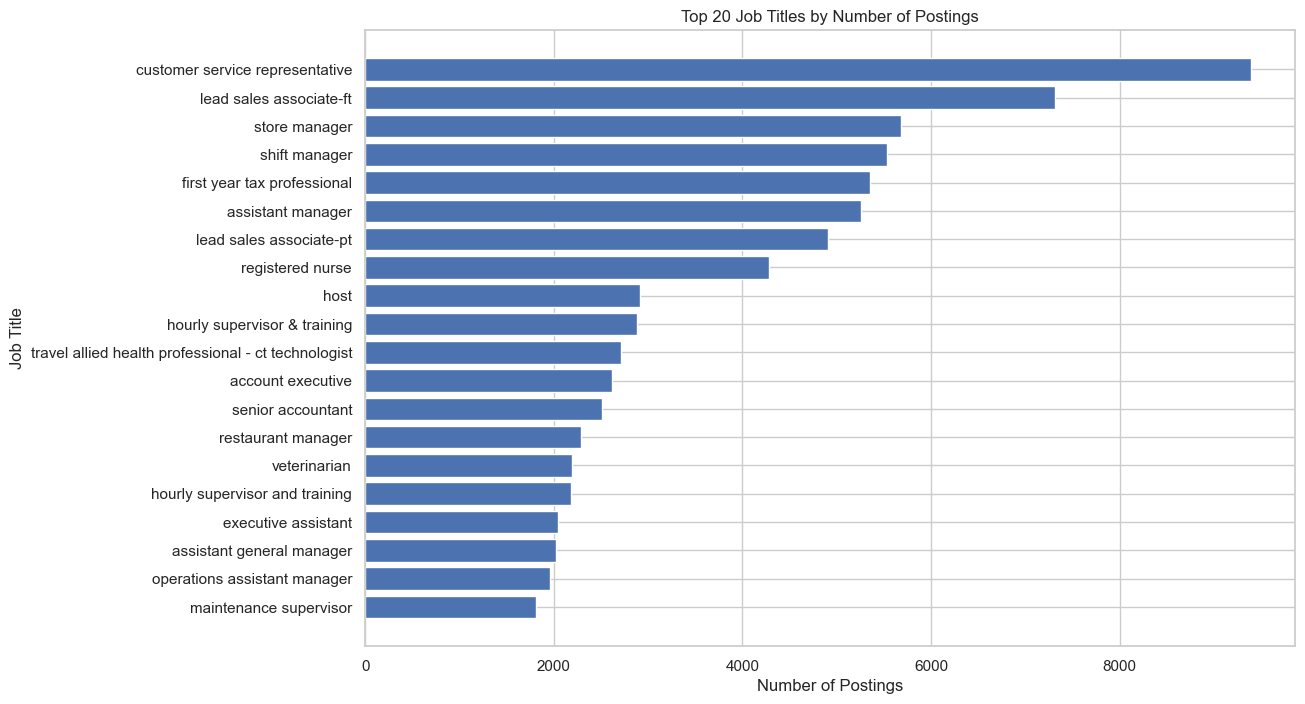

In [56]:
# Rank job titles by count
job_title_ranking = df_postings_skills.groupBy('job_title').count().orderBy('count', ascending=False)
job_title_ranking_pd = job_title_ranking.limit(20).toPandas()

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(job_title_ranking_pd['job_title'], job_title_ranking_pd['count'])
plt.xlabel('Number of Postings')
plt.ylabel('Job Title')
plt.title('Top 20 Job Titles by Number of Postings')
plt.gca().invert_yaxis()
plt.show()

# IT Job Deep Dive

In [57]:
df_postings_skills.select("job_title").distinct().show()

+--------------------+
|           job_title|
+--------------------+
|assistant manager...|
|   builder/carpenter|
|business support ...|
|      client manager|
|cloud infrastruct...|
|ct/general radiog...|
|motor claims cons...|
|o&g registrar - u...|
|quality & food sa...|
|registered nurses...|
|(can) vision cent...|
|contremaître de c...|
|financial complia...|
|geotechnical engi...|
|kantinenköchin/ko...|
|member services r...|
|operations consul...|
|operations manage...|
|quality auditor -...|
|registered veteri...|
+--------------------+
only showing top 20 rows


In [ ]:
# IT Keyword Filter Definition
strict_keywords = [
    "AI", "IT", "Web", "QA", "UI", "UX", "ML", "SRE", "NLP", "IOT", "ERP", "SAAS", 
    "API", "SDK", "ETL", "BI", "DBA", "AR", "VR", "XR", "GIS"
]
broad_keywords = [
    "Software", "Developer", "Engineer", "Data", "Analyst", "Cyber", 
    "Cloud", "Network", "System", "Database", "Machine Learning", 
    "DevOps", "Programmer", "Technical", "Information Technology",
    "Security", "Architect", "Scrum", "Product Owner", "Java", "Python", "Javascript",
    "Full Stack", "Backend", "Frontend", "Mobile", "Firmware", "Blockchain", 
    "Data Scientist", "Robotics", "Automation", "Reliability", "Platform", "Infrastructure",
    "Support", "Technician", "Help Desk", "Service Desk", "Admin", "SysAdmin"
]
tech_keywords = [
    "React", "Angular", "Vue", "Node", "AWS", "Azure", "GCP", "Linux", "Docker", 
    "Kubernetes", "Terraform", "Ansible", "Jenkins", "Salesforce", "Oracle", "SAP", 
    "C#", "C++", "Golang", "Rust", "Swift", "Kotlin", "Flutter", "TensorFlow", "PyTorch"
]

strict_regex = "|".join([f"\\b{k}\\b" for k in strict_keywords])
broad_regex = "|".join(broad_keywords)
tech_regex = "|".join([f"\\b{k}\\b" for k in tech_keywords])
combined_regex = f"(?i)({strict_regex}|{broad_regex}|{tech_regex})"

# Exclusion keywords (Refined based on validation)
exclusion_keywords = [
    "Civil", "Mechanical", "Chemical", "Nurse", "Driver", "Construction", 
    "Financial Analyst", "Accountant", "Sales Manager", "Office Manager", "Clerk",
    "Electrician", "Plumber", "Store Manager", "Warehouse", "Operator", "Technician I", "Technician II", "Technician III"
    "Pharmacy", "Medical", "Dental", "Legal"
]
exclusion_regex = "|".join(exclusion_keywords)
combined_exclusion = f"(?i)({exclusion_regex})"

# Apply Filter (Include IT keywords AND Exclude Non-IT keywords)
df_it_jobs = df_postings.filter(
    col("job_title").rlike(combined_regex) & 
    ~col("job_title").rlike(combined_exclusion)
)

print(f"Total Jobs: {df_postings_skills.count()}")
print(f"IT Jobs Filtered: {df_it_jobs.count()}")


Total Jobs: 1296381


IT Jobs Filtered: 223190


In [32]:
print(f"df_job_skills: {df_postings_skills.count()} rows")

# IT Keyword Filter
strict_keywords = ["AI", "IT", "Web", "QA", "UI", "UX", "ML"]
broad_keywords = [
    "Software", "Developer", "Engineer", "Data", "Analyst", "Cyber", 
    "Cloud", "Network", "System", "Database", "Machine Learning", 
    "DevOps", "Programmer", "Technical", "Information Technology",
    "Security", "Architect", "Scrum", "Product Owner", "Java", "Python", "Javascript"
]

strict_regex = "|".join([f"\\b{k}\\b" for k in strict_keywords])
broad_regex = "|".join(broad_keywords)
combined_regex = f"(?i)({strict_regex}|{broad_regex})"

df_it_jobs = df_postings_skills.filter(col("job_title").rlike(combined_regex))

print(f"df_it_jobs: {df_it_jobs.count()} rows")

df_it_jobs.show(5)


df_job_skills: 1296381 rows


df_it_jobs: 182917 rows


+--------------------+--------------------+-----------+-------+---------------+--------------------+----------------+--------------------+----------+-----------+--------------+--------------------+----------+--------+--------------------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|           job_title|         company|        job_location|first_seen|search_city|search_country|     search_position| job_level|job_type|          job_skills|
+--------------------+--------------------+-----------+-------+---------------+--------------------+----------------+--------------------+----------+-----------+--------------+--------------------+----------+--------+--------------------+
|https://ae.linked...|2024-01-21 03:25:...|          t|      t|              f|Project Operation...|          Taqeef|Dubai, United Ara...|2024-01-14|   San Jose| United States|  Standards Engineer| Associate|  Onsite|Project Managemen...|
|https://au.linked...|2024-01-19 09:45:...| 